In [1]:
%%time

import glob

import geopandas as gpd
import matplotlib.pyplot as plt
import numba
import numpy as np
import pandas as pd
from libpysal.graph import read_parquet
from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler

from sklearn.neighbors import KDTree

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import davies_bouldin_score
from core.cluster_validation import get_linkage_matrix

from fast_hdbscan.cluster_trees import (
    cluster_tree_from_condensed_tree,
    condense_tree,
    extract_eom_clusters,
    extract_leaves,
    get_cluster_label_vector,
    mst_to_linkage_tree,
)
from sklearn.neighbors import KDTree
import shapely
from core.cluster_validation import generate_detailed_clusters
from core.generate_context import spatially_weighted_partial_lag
from core.generate_clusters import cluster_data

CPU times: user 11.2 s, sys: 398 ms, total: 11.6 s
Wall time: 9.26 s


In [2]:
region_id = 69333

tessellations_dir = '/data/uscuni-ulce/processed_data/tessellations/'
chars_dir = "/data/uscuni-ulce/processed_data/chars/"
graph_dir = "/data/uscuni-ulce/processed_data/neigh_graphs/"
cluster_dir = '/data/uscuni-ulce/processed_data/clusters/'
val_path = '../data/prague_validation/morphotopes.pq'

In [3]:
# region_id = 'freiburg'
# buildings_dir = streets_dir = enclosures_dir = tessellations_dir = graph_dir = '../data/freiburg/'
# chars_dir = '../data/freiburg/chars/'
# cluster_dir = '/data/uscuni-ulce/processed_data/clusters/'
# val_path = '../data/fbg_cluster_validation.pq'

In [4]:
X_train = pd.read_parquet(chars_dir + f'primary_chars_{region_id}.parquet')
graph = read_parquet(graph_dir + f"tessellation_graph_{region_id}_knn1.parquet")
tessellation = gpd.read_parquet(
        tessellations_dir + f"tessellation_{region_id}.parquet"
)
morphotopes = gpd.read_parquet(val_path)

In [5]:


tess_groups = generate_detailed_clusters(tessellation,
                                         include_random_sample=False, path=val_path)
tess_groups = tess_groups[tess_groups.index.isin(X_train.index)]


tess_groups_ilocs = (
    pd.Series(np.arange(len(X_train[X_train.index >=0])), index=X_train[X_train.index >=0].index)
    .loc[tess_groups.index]
    .values
)

In [6]:
spatial_lags = [1, 2, 3, 4, 5]
kernels = ['gaussian', 'inverse', 'weights']
lag_types = ['_median', '_iqr', '_']
cluster_sizes = [50, 75, 100, 150, 250]
chars_to_drop = [
    [],
    ['stcSAl', 'stcOri'],
    [
       'stcSAl',
       'ltkOri',
         'stbOri',
         'stcOri',
         'stbCeA'
    ]
          
]
clips = [None, (-5,5), (-10, 10)]


linkage = 'ward'
metric = 'euclidean'
centroids = shapely.get_coordinates(tessellation.representative_point())

In [30]:
from core.generate_clusters import preprocess_clustering_data, get_clusters, post_process_clusters, get_tree
# # label building input data, could work with empty tess as well
building_graph = graph.subgraph(graph.unique_ids[graph.unique_ids >= 0])
labels = building_graph.component_labels

In [31]:
min_cluster_size = 100
spatial_lag = 3
kernel='gaussian'

to_drop = []
# to_drop = ['stcSAl', 'stcOri']
to_drop = [
       'stcSAl',
       'ltkOri',
         'stbOri',
         'stcOri',
         'stbCeA'
]

lag_type = '_iqr'

clip = None
linkage='ward'
metric='euclidean'

In [32]:
%%time
lag = spatially_weighted_partial_lag(X_train, graph, centroids, kernel=kernel, k=spatial_lag, n_splits=10)
lag = lag[[c for c in lag.columns if lag_type in c]]
clustering_data = X_train.join(lag, how='inner')

CPU times: user 4min 18s, sys: 24.3 s, total: 4min 42s
Wall time: 37.5 s


In [33]:
# clustering_data = X_train.copy()
# clip = (-3,3)
# to_drop = [
#        'stcSAl',
#        'ltkOri',
#          'stbOri',
#          'stcOri',
#          'stbCeA'
# ]

In [34]:
clustering_data.shape

(460909, 126)

In [35]:
%%time
region_cluster_labels = cluster_data(clustering_data, graph, to_drop, clip, min_cluster_size, linkage, metric)

CPU times: user 57.7 s, sys: 575 ms, total: 58.3 s
Wall time: 58 s


In [36]:
from sklearn.metrics import silhouette_score

In [37]:
silhouette_score(clustering_data.iloc[tess_groups_ilocs].fillna(0), region_cluster_labels[tess_groups_ilocs])

np.float64(-0.6183644409538975)

In [38]:
adjusted_rand_score(tess_groups.values, region_cluster_labels[tess_groups_ilocs])

0.6178865658566751

In [39]:
# gpd.read_parquet('../data/morphotopes_freiburg_100_3_gaussian.pq').explore()

In [40]:
labels.value_counts()

component labels
184     140690
125      21682
28       10205
61        6061
74        5738
         ...  
2455         1
0            1
3439         1
3434         1
3414         1
Name: count, Length: 3458, dtype: int64

In [41]:
label = 184
labels.groupby(labels).get_group(label).shape

(140690,)

In [42]:
# tessellation.loc[labels.groupby(labels).get_group(label).index.values].explore(column=results[label], categorical=True)

In [43]:
# buildings = gpd.read_parquet(f'/data/uscuni-ulce/processed_data/buildings/buildings_{region_id}.parquet')

In [44]:
## there is some issue here with the subsetting

In [45]:
plotting = tessellation.loc[labels.groupby(labels).get_group(label).index.values].reset_index()
# plotting['label'] = region_cluster_labels[region_cluster_labels.str.startswith(str(label))].values
plotting['label'] = region_cluster_labels.loc[labels.groupby(labels).get_group(label).index.values].values
# plotting['label'] = plotting['label']
plotting['label'] = plotting['label'].str.split('_').str[1].astype(int)
plotting.shape

(140690, 4)

In [46]:
# layer.get_fill_color = get_color(plotting['label'].values)

In [47]:
plotting['label'].nunique()

727

In [48]:
# buildings = gpd.read_parquet(buildings_dir + 'buildings_freiburg.parquet')
# plotting = buildings

In [49]:
%%time
import lonboard
layer = lonboard.SolidPolygonLayer.from_geopandas(plotting, opacity=.08)

/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/lonboard/_geoarrow/ops/reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")


CPU times: user 2.47 s, sys: 204 ms, total: 2.67 s
Wall time: 2.67 s


In [50]:
from sidecar import Sidecar
sc = Sidecar(title='Morphotopes')
m = lonboard.Map(layer, basemap_style=lonboard.basemap.CartoBasemap.Positron)
with sc:
    display(m)

from core.cluster_validation import get_color
layer.get_fill_color = get_color(plotting['label'].values)

In [51]:
%%time

clrs_geometry = tessellation.loc[region_cluster_labels.index]
clrs_geometry['label'] = region_cluster_labels.values
clrs_geometry = clrs_geometry.dissolve('label').simplify(1).to_frame()
clrs_geometry.columns = ['geometry']
morph_clrs_geometry = clrs_geometry.set_geometry('geometry').reset_index()

CPU times: user 34.3 s, sys: 0 ns, total: 34.3 s
Wall time: 34.3 s


In [52]:
morph_clrs_geometry.to_parquet(f'../data/morphotopes_{region_id}_{min_cluster_size}_{spatial_lag}_{lag_type}_{kernel}.pq')

In [53]:
# gpd.read_parquet(f'../data/morphotopes_{region_id}_{min_cluster_size}_{spatial_lag}_{lag_type}_{kernel}.pq').explore()

----

In [54]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

In [55]:
# component_data = X_train.loc[labels.groupby(labels).get_group(label).index.values]

component_data = X_train.loc[region_cluster_labels.index]

In [56]:
# component_data = component_data.groupby(results[label]).agg([np.min, np.median, np.max])

In [57]:
# component_data = component_data.groupby(results[label]).agg([percentile(10), 
#                                                              'median', 
#                                                              percentile(90)])

In [58]:
%%time
component_data = component_data.groupby(region_cluster_labels.values).agg([percentile(10), 
                                                             'median', 
                                                             percentile(90)])

CPU times: user 30.1 s, sys: 0 ns, total: 30.1 s
Wall time: 30.1 s


In [59]:
component_data

sdbAre                                  sdbPer             \
         percentile_10      median percentile_90 percentile_10     median   
0_1.0       137.301434  137.301434    137.301434     49.637208  49.637208   
1000_1.0    244.267461  244.267461    244.267461     62.540334  62.540334   
1001_0       38.465440   92.807458    159.370943     26.071664  40.541902   
1001_1       42.144753  105.590384    184.565733     26.978835  43.173789   
1001_2       38.026105  141.789961    386.963486     25.038969  50.255788   
...                ...         ...           ...           ...        ...   
997_1.0      29.112050   49.390391    189.078623     22.304253  28.283954   
998_1.0     234.198102  234.198102    234.198102     62.268113  62.268113   
999_1.0      12.033956   12.033956     12.033956     15.353528  15.353528   
99_1.0      127.013402  127.013402    127.013402     58.488908  58.488908   
9_0          65.028669  141.260134    287.622403     34.486032  55.486851   

                              sdbCoA                             ssbCCo  ...  \
         percentile_90 percentile_10 median percentile_90 percentile_10  ...   
0_1.0        49.637208           0.0    0.0           0.0      0.511269  ...   
1000_1.0     62.540334           0.0    0.0           0.0      0.634879  ...   
1001_0       55.958840           0.0    0.0           0.0      0.370904  ...   
1001_1       66.537560           0.0    0.0           0.0      0.384219  ...   
1001_2       92.705822           0.0    0.0           0.0      0.307147  ...   
...                ...           ...    ...           ...           ...  ...   
997_1.0      72.773745           0.0    0.0           0.0      0.353755  ...   
998_1.0      62.268113           0.0    0.0           0.0      0.594390  ...   
999_1.0      15.353528           0.0    0.0           0.0      0.438574  ...   
99_1.0       58.488908           0.0    0.0           0.0      0.343718  ...   
9_0          92.223459           0.0    0.0           0.0      0.280456  ...   

                ltkWNB        likWBB                                 sdsAre  \
         percentile_90 percentile_10    median percentile_90  percentile_10   
0_1.0         0.001476      0.003765  0.003765      0.003765   41562.935499   
1000_1.0      0.003213      0.010122  0.010122      0.010122   93440.052025   
1001_0        0.013287      0.070665  0.089576      0.175980    3807.735801   
1001_1        0.014477      0.062655  0.099869      0.140583    3277.393739   
1001_2        0.003799      0.033377  0.033377      0.088830   10184.564569   
...                ...           ...       ...           ...            ...   
997_1.0       0.000801      0.005378  0.005378      0.005378   29125.350454   
998_1.0       0.001449      0.006191  0.006191      0.006191   90239.346574   
999_1.0       0.003557      0.000596  0.000596      0.000596   67044.480363   
99_1.0        0.003809      0.006904  0.006904      0.006904  209571.584468   
9_0           0.009104      0.037235  0.058266      0.121364    8429.834762   

                                              likWCe                          
                 median  percentile_90 percentile_10    median percentile_90  
0_1.0      41562.935499   41562.935499      0.000027  0.000027      0.000027  
1000_1.0   93440.052025   93440.052025      0.000041  0.000041      0.000041  
1001_0      8777.087515   19241.865819      0.000294  0.000970      0.001823  
1001_1      9562.504605   24341.181719      0.000543  0.000983      0.001270  
1001_2     27194.403381  165529.626539      0.000146  0.000146      0.000629  
...                 ...            ...           ...       ...           ...  
997_1.0    61349.486994   66872.244029      0.000060  0.000060      0.000060  
998_1.0    90239.346574   90239.346574      0.000026  0.000026      0.000026  
999_1.0    67044.480363   67044.480363      0.000049  0.000049      0.000049  
99_1.0    209571.584468  209571.584468      0.000054  0.000054      0.000054

In [60]:
vals = StandardScaler().fit_transform(component_data)
component_data = pd.DataFrame(vals, columns=component_data.columns, index=component_data.index)
component_data = component_data.drop(component_data.columns[component_data.std() == 0], axis=1)

In [61]:

# component_data = component_data[component_data.index >= 0]
vals = np.nan_to_num(component_data)
component_data = pd.DataFrame(vals, columns=component_data.columns, index=component_data.index)

In [62]:
# component_data = component_data.clip(-10, 10)

In [63]:
# component_data = component_data[component_data.columns[component_data.columns.get_level_values(1).str.contains('median')]]

In [64]:
# dists, component_data.iloc[idxs[0]].index

In [65]:
# from sklearn.neighbors import KDTree
# tree = KDTree(component_data.values)
# dists, idxs = tree.query(component_data.loc[['3_6']].values, k=10)

# morph_clrs_geometry.set_index('label').loc[component_data.iloc[idxs[0]].index].explore(column=dists[0], )

In [66]:
umap_metric ='euclidean'
n_neighbors = 10

/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc 

<Axes: >

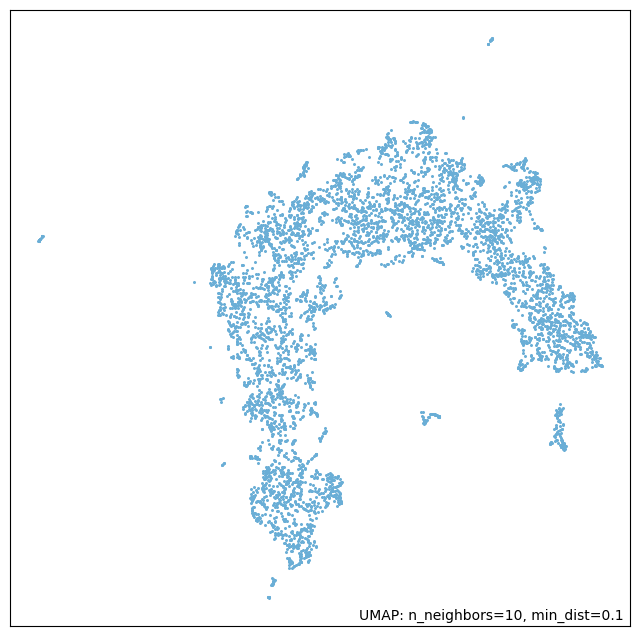

In [67]:
import umap
import umap.plot
reducer = umap.UMAP(n_neighbors=n_neighbors, n_components=2, 
                    negative_sample_rate=50, min_dist=0.1, metric=umap_metric, verbose=False, random_state=1)
emb = reducer.fit_transform(component_data)
umap.plot.points(reducer)

In [68]:
reducer = umap.UMAP(n_neighbors=n_neighbors, n_components=20, 
                    min_dist=0, negative_sample_rate=50, 
                    metric=umap_metric, verbose=True, random_state=1)
embedding = reducer.fit_transform(component_data)

/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(min_dist=0, n_components=20, n_jobs=1, n_neighbors=10, negative_sample_rate=50, random_state=1, verbose=True)
Mon Sep 16 10:06:06 2024 Construct fuzzy simplicial set
Mon Sep 16 10:06:06 2024 Finding Nearest Neighbors
Mon Sep 16 10:06:06 2024 Building RP forest with 9 trees
Mon Sep 16 10:06:06 2024 NN descent for 12 iterations
	 1  /  12
	 2  /  12
	 3  /  12
	 4  /  12
	 5  /  12
	Stopping threshold met -- exiting after 5 iterations
Mon Sep 16 10:06:06 2024 Finished Nearest Neighbor Search
Mon Sep 16 10:06:06 2024 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Mon Sep 16 10:06:51 2024 Finished embedding


In [69]:
tr_data = embedding
# tr_data = component_data

In [70]:
final_linkage = 'ward'
final_metric = 'euclidean'

In [71]:
clusterer = AgglomerativeClustering(linkage=final_linkage,
                                    metric=final_metric,
                                    compute_full_tree=True,
                                    compute_distances=True)
model = clusterer.fit(tr_data)
linkage_matrix = get_linkage_matrix(model)

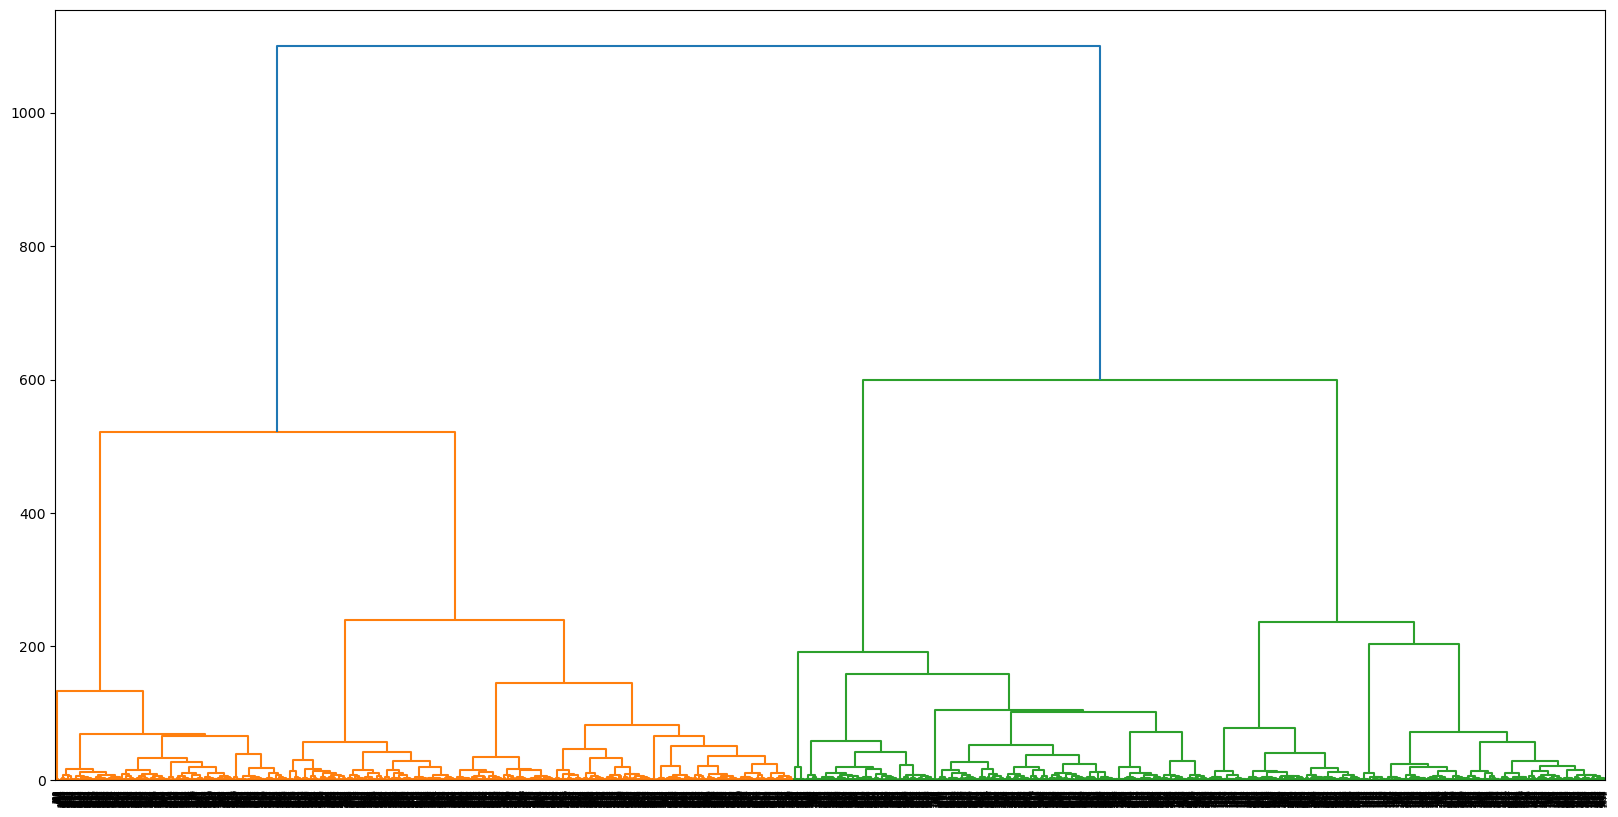

In [72]:
fig,ax = plt.subplots(figsize=(20,10))
_ = dendrogram(linkage_matrix, ax=ax)

In [75]:
cutoff = 100

In [76]:
clusters = fcluster(linkage_matrix, t=cutoff, criterion='distance')
np.unique(clusters)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13], dtype=int32)

In [77]:
# gpd.read_parquet('../data/clusters_umap_freiburg_100_3_gaussian_euclidean_complete_chebyshev_5.pq').explore()

In [78]:


# from sklearn.cluster import KMeans, MiniBatchKMeans
# from sklearn.metrics import adjusted_rand_score
# clusters = KMeans(n_clusters=15, max_iter=5000, n_init=300, random_state=1).fit(tr_data).labels_
# np.unique(clusters)

In [79]:

# import hdbscan
# clusterer = hdbscan.HDBSCAN(min_cluster_size=n_neighbors)
# clusterer.fit(component_data)
# clusters = clusterer.labels_
# np.unique(clusters)

In [80]:
# morh_clusters = results[label]
morh_clusters = region_cluster_labels.values
clusters = pd.Series(clusters, index=component_data.index.values)
clusters = clusters.loc[morh_clusters].values

In [81]:
# layer.get_fill_color = get_color(clusters)

In [82]:
# assert clusters.shape == results[label].shape

# for i in np.unique(results[label]):
#     idxs = np.where(results[label] == i)[0]
#     old_clusters = results[label][idxs]
#     new_clusters = clusters[idxs]
#     assert np.unique(old_clusters).shape[0] == 1
#     assert np.unique(new_clusters).shape[0] == 1
    

In [83]:
%%time
import lonboard
# plotting = tessellation[tessellation.index.isin(X_train.index)].copy()
layer = lonboard.SolidPolygonLayer.from_geopandas(tessellation[tessellation.index >= 0], opacity=.08)

/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/lonboard/_geoarrow/ops/reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")


CPU times: user 7.3 s, sys: 413 ms, total: 7.71 s
Wall time: 7.71 s


In [84]:
from sidecar import Sidecar
sc = Sidecar(title='Final Clusters')
m = lonboard.Map(layer, basemap_style=lonboard.basemap.CartoBasemap.Positron)
with sc:
    display(m)

In [85]:
from core.cluster_validation import get_color
layer.get_fill_color = get_color(clusters)

In [284]:
# gpd.read_parquet(f'../data/clusters_umap_{region_id}_{min_cluster_size}_{spatial_lag}_{kernel}_{umap_metric}_{final_linkage}_{final_metric}_{cutoff}.pq').explore()

In [285]:
fbc = gpd.read_parquet('../data/freiburg/freiburg_building_census.pq')

In [86]:
clrs_geometry = tessellation.loc[region_cluster_labels.index]
clrs_geometry['label'] = clusters
clrs_geometry = clrs_geometry.dissolve('label').simplify(1).to_frame()
clrs_geometry.columns = ['geometry']
clrs_geometry = clrs_geometry.set_geometry('geometry')
clrs_geometry = clrs_geometry.reset_index()

In [287]:
# Overlay cells with clusters to get intersections
overlap = gpd.overlay(fbc, clrs_geometry, how='intersection')

# Calculate the area of overlap
overlap['area'] = overlap.geometry.area

# Find the cluster with the largest overlap for each cell
largest_overlap = overlap.loc[overlap.groupby(overlap['ID'])['area'].idxmax()]

/tmp/ipykernel_589934/715595176.py:2: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  overlap = gpd.overlay(fbc, clrs_geometry, how='intersection')


In [288]:
cols = largest_overlap.columns[largest_overlap.columns.str.contains('19') | largest_overlap.columns.str.contains('19')].sort_values()
age_cols = [cols[-1]] + list(cols[:-1])
age_cols

res = largest_overlap.iloc[:, 2:].dissolve('label', aggfunc='sum')
res[age_cols]

,Before 1919,1919 - 1948,1949 - 1978,1979 - 1986,1987 - 1990,1991 - 1995,1996 - 2000
label,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,0.0,0.0,0.0,0.0,0.0,0.0
3,535.0,118.0,359.0,69.0,6.0,19.0,18.0
4,1385.0,406.0,704.0,74.0,23.0,18.0,21.0
5,179.0,889.0,1000.0,174.0,34.0,21.0,43.0
6,200.0,151.0,402.0,13.0,10.0,18.0,135.0
7,81.0,319.0,1074.0,186.0,40.0,33.0,55.0
8,41.0,100.0,648.0,77.0,19.0,30.0,40.0
9,0.0,0.0,106.0,27.0,16.0,6.0,86.0


In [289]:
from sklearn import model_selection, ensemble, metrics
ind = largest_overlap.columns[2:-3]

X_train_rf, X_test, y_train, y_test = model_selection.train_test_split(largest_overlap[ind], largest_overlap["label"].astype(str), test_size=0.25, random_state=0)
model = ensemble.RandomForestClassifier(random_state=0, n_jobs=-1)
model.fit(X_train_rf, y_train)
pred = model.predict(X_test)

accuracy = metrics.accuracy_score(pred, y_test)
kappa = metrics.cohen_kappa_score(pred, y_test)

summary = f"""\
Evaluation metrics
==================
Basic model:
  Accuracy: {round(accuracy, 3)}
  Kappa:    {round(kappa, 3)}
"""

print(summary)

Evaluation metrics
Basic model:
  Accuracy: 0.347
  Kappa:    0.268



In [290]:
from sklearn import model_selection, ensemble, metrics
ind = largest_overlap.columns[2:-3]

X_train_rf, X_test, y_train, y_test = model_selection.train_test_split(largest_overlap[age_cols], largest_overlap["label"].astype(str), test_size=0.25, random_state=0)
model = ensemble.RandomForestClassifier(random_state=0, n_jobs=-1)
model.fit(X_train_rf, y_train)
pred = model.predict(X_test)

accuracy = metrics.accuracy_score(pred, y_test)
kappa = metrics.cohen_kappa_score(pred, y_test)

summary = f"""\
Evaluation metrics
==================
Basic model:
  Accuracy: {round(accuracy, 3)}
  Kappa:    {round(kappa, 3)}
"""

print(summary)

Evaluation metrics
Basic model:
  Accuracy: 0.231
  Kappa:    0.125



In [291]:
pd.Series(model.feature_importances_, index=model.feature_names_in_).sort_values(ascending=False).iloc[:10]


1949 - 1978    0.320713
Before 1919    0.245733
1919 - 1948    0.212132
1979 - 1986    0.104255
1996 - 2000    0.065185
1991 - 1995    0.027025
1987 - 1990    0.024956
dtype: float64

In [89]:
clrs_geometry.to_parquet(f'../data/clusters_umap_{region_id}_{min_cluster_size}_{spatial_lag}_{kernel}_{umap_metric}_{final_linkage}_{final_metric}_{cutoff}.pq')

In [293]:
component_data.to_parquet(f'../data/morphotopes_data_{region_id}_{min_cluster_size}_{spatial_lag}_{lag_type}_{kernel}.pq')

In [ ]:
# gkf = model_selection.StratifiedGroupKFold(n_splits=5)
# splits = gkf.split(
#     largest_overlap[ind],
#     largest_overlap["label"].astype(str),
#     groups=largest_overlap["label"],
# )

In [ ]:
# split_label = np.empty(len(largest_overlap), dtype=float)
# for i, (train, test) in enumerate(splits):
#     split_label[test] = i
# largest_overlap["split"] = split_label

In [ ]:
# ax = largest_overlap.plot(
#   "split", categorical=True, figsize=(9, 9), markersize=0.1, legend=True
# )
# largest_overlap.dissolve("label").convex_hull.boundary.plot(
#     ax=ax, color="k", linewidth=0.5, markersize=0
# )
# ax.set_axis_off()

In [ ]:
from libpysal import graph
import esda


In [ ]:
col = '1979 - 1986'

In [ ]:
contiguity = graph.Graph.build_contiguity(fbc, rook=False)
contiguity_r = contiguity.transform("r")
lisa = esda.Moran_Local(fbc[col].fillna(0), contiguity_r)

In [ ]:
# lisa.explore(
# fbc,
# crit_value=0.05,
#   prefer_canvas=True,
#   tiles="CartoDB Positron",
# )